In [1]:
import yfinance as yf
import pandas_ta as ta
import pandas as pd
import numpy as np
import finplot as fplt

# Getting Data
We utilise the yfinance module to scrape OHLC data for 'company' from dates 01/01/18 to 01/01/21.


Dates 01/02/23 to 28/01/23 will be used for backtesting.

In [2]:
#Company="BB" Period=10 years
#Train: 2014-2021
#Test: 2022-2024
df = yf.download("AAPL", period="15y")
df["Change"] = df["Close"] - df["Open"]
df["Change %"] = (df["Change"] / df["Open"])*100
train=df.iloc[:1500]
test=df.iloc[1500:]
names=[]
for col in df.columns:
    df.rename(columns={col:col.lower()},inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj close,volume,change,change %
Date,,,,,,,,
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.863341,1181608400,0.050357,1.513354
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.816114,1289310400,-0.104643,-3.053674
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.755262,753048800,-0.028572,-0.871385
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.806425,673500800,0.081071,2.510212
2009-01-09,3.328929,3.335000,3.219286,3.235000,2.742244,546845600,-0.093929,-2.821600
...,...,...,...,...,...,...,...,...
2023-12-28,194.139999,194.660004,193.169998,193.580002,193.580002,34049900,-0.559998,-0.288450
2023-12-29,193.899994,194.399994,191.729996,192.529999,192.529999,42628800,-1.369995,-0.706547
2024-01-02,187.149994,188.440002,183.889999,185.639999,185.639999,82488700,-1.509995,-0.806837


In [3]:
def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()

    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return plus_di, minus_di, adx_smooth

def NormToPi(ARR):
    Arr = np.copy(ARR)
    K1 = 10
    while(Arr[len(Arr)-1]/K1 > 1): K1 *= 10
    LX = Arr[len(Arr)-1]/K1
    K2 = 1
    while(LX * K2 < np.pi): K2 += 0.01
    K2-= 0.01
    return [ (Value/K1)*K2  for Value in Arr]

def Operator(XS, YS, N = 100, Fr = "4.1"):
    Xs = NormToPi(XS)
    Ys = np.copy(YS)

    def F(x, E=0.01):
        while(E < 100):
            Nm = 0
            for Value in Xs:
                if (abs(x - Value) < E):
                    return Ys[Nm]
                Nm += 1
            E *= 10

    def S(k, x, n = 100):
        Sn = (((-1) ** k) * np.sin(n * x)) / (n * x - k * np.pi)
        return Sn

    def Ln(f, x, n = 100):
        LN = 0
        for k in range(1, n):
            Sk = S(k,x,n)
            xi = (k * np.pi) / n
            LN +=  Sk * F(xi)
        return LN

    def Ah(f, x, n = 100):
        AH = 0
        for k in range(1, n):
            AH += (((S(k-1, x, n) + S(k, x, n)) * f(k * (np.pi/n)))/2)
        return AH

    if(Fr == "4.1"):     return [Ln(F, x, n = N) for x in Xs]
    if(Fr == "5.38"):   return [Ah(F, x, n = N) for x in Xs]

In [4]:
df['plus_di'] = pd.DataFrame(get_adx(df['high'], df['low'], df['close'], 14)[0]).rename(columns = {0:'plus_di'})
df['minus_di'] = pd.DataFrame(get_adx(df['high'], df['low'], df['close'], 14)[1]).rename(columns = {0:'minus_di'})
df['adx'] = pd.DataFrame(get_adx(df['high'], df['low'], df['close'], 14)[2]).rename(columns = {0:'adx'})

In [5]:
df[['close','plus_di','minus_di','adx']].plot(figsize=(12,10), color=['black','green','red','orange'])

In [6]:
def HA(df, ohlc=['open', 'high', 'low', 'close']):
    '''
    Function to compute Heiken Ashi Candles (HA)

    Args :
        df : Pandas DataFrame which contains ['date', 'open', 'high', 'low', 'close', 'volume'] columns
        ohlc: List defining OHLC Column names (default ['open', 'high', 'low', 'close'])

    Returns :
        df : Pandas DataFrame with new columns added for
            Heiken Ashi Close (HA_$ohlc[3])
            Heiken Ashi Open (HA_$ohlc[0])
            Heiken Ashi High (HA_$ohlc[1])
            Heiken Ashi Low (HA_$ohlc[2])'''


    ha_open = 'HA_' + ohlc[0]
    ha_high = 'HA_' + ohlc[1]
    ha_low = 'HA_' + ohlc[2]
    ha_close = 'HA_' + ohlc[3]

    df[ha_close] = (df[ohlc[0]] + df[ohlc[1]] + df[ohlc[2]] + df[ohlc[3]]) / 4

    df[ha_open] = 0.00
    for i in range(0, len(df)):
        if i == 0:
            df[ha_open].iat[i] = (df[ohlc[0]].iat[i] + df[ohlc[3]].iat[i]) / 2
        else:
            df[ha_open].iat[i] = (df[ha_open].iat[i - 1] + df[ha_close].iat[i - 1]) / 2

    df[ha_high]=df[[ha_open, ha_close, ohlc[1]]].max(axis=1)
    df[ha_low]=df[[ha_open, ha_close, ohlc[2]]].min(axis=1)

    return df

In [7]:
df=HA(df)


In [8]:
fplt.candlestick_ochl(df[['HA_open', 'HA_close', 'HA_high', 'HA_low']])

# Creating Heiken-Ashi candle data
This allows us to normalize and smoothen the curves, helping us reduce noise and have a clearer idea of the undelying trend.


In [9]:
'''use ta to get candlestick data'''

'''put graphs and visualize this data'''

'''remember to use adj_close and not close'''

'remember to use adj_close and not close'

In [10]:


# Create a new dataframe with only the 'Close column 
data = df.filter(['HA_close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .45 ))

training_data_len



1700

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00257675],
       [0.00266323],
       [0.00207064],
       ...,
       [0.94004891],
       [0.93064432],
       [0.91815184]])

In [12]:


# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00257675, 0.00266323, 0.00207064, 0.0021045 , 0.00214981,
       0.00170822, 0.00145105, 0.00106209, 0.00035647, 0.00050702,
       0.        , 0.0001867 , 0.00145929, 0.00142863, 0.00171326,
       0.00191643, 0.00240194, 0.00241155, 0.00210633, 0.0018844 ,
       0.00220701, 0.00255295, 0.00268932, 0.00335924, 0.00387496,
       0.00358759, 0.00306318, 0.00321922, 0.00347227, 0.00285497,
       0.00263852, 0.00219831, 0.00190682, 0.00168305, 0.0016135 ,
       0.00196127, 0.00195578, 0.00164187, 0.0015833 , 0.0016286 ,
       0.00197866, 0.00179791, 0.00110007, 0.00078387, 0.00122179,
       0.00209627, 0.0026312 , 0.00293367, 0.00289157, 0.00317254,
       0.00385757, 0.00396236, 0.00398249, 0.00457371, 0.00491279,
       0.00484873, 0.0052592 , 0.00501896, 0.00440623, 0.0046991 ])]
[0.004820359558327219]

[array([0.00257675, 0.00266323, 0.00207064, 0.0021045 , 0.00214981,
       0.00170822, 0.00145105, 0.00106209, 0.00035647, 0.00050702,
       0.        , 0.0001867 , 0.0

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)





1640/1640 [==============================] - 26s 14ms/step - loss: 7.0912e-05


In [ ]:
# Implementing Evaluation Metrics
def calculate_drawdown_percentage(portfolio_values):
    max_drawdowns = []
    peak_value = portfolio_values[0]
    for i in range(1, len(portfolio_values)):
        peak_value = max(peak_value,portfolio_values[i])
        drawdown = (peak_value-portfolio_values[i]) / peak_value * 100
        max_drawdowns.append(drawdown)

    return max(max_drawdowns)
def calculate_sharpe_ratio(df, risk_free_rate):
    df['Daily Return'] = df['portfolio'].pct_change(1)
    Sharpe_Ratio = (df['Daily Return'].mean() - risk_free_rate) / df['Daily Return'].std()
    A_SharpeRatio = (252 ** 0.5) * Sharpe_Ratio
    df.drop(columns = ['Daily Return'])
    return A_SharpeRatio

def calculate_sortino_ratio(df, risk_free_rate, weights = [1.0]):
    returns = df['portfolio'].pct_change(1).dropna()
    negative_returns = returns[returns < 0]
    downside_std = np.std(negative_returns)
    exp_rets = returns.mean()
    mean = np.dot(exp_rets, weights)
    excess_return = mean - risk_free_rate
    sortino_ratio = excess_return / downside_std
    return sortino_ratio

In [14]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

65/65 [==============================] - 2s 16ms/step


19.42208838752638

In [15]:
import matplotlib.pyplot as plt

C:\Users\alanr\AppData\Local\Temp\ipykernel_32220\1047477567.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


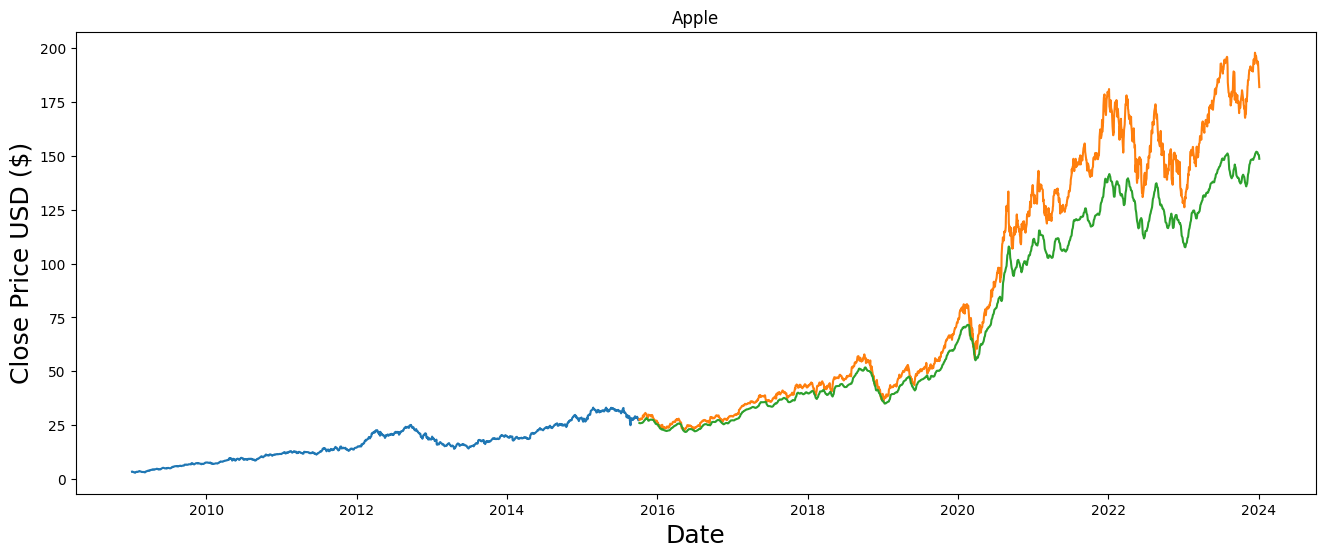

In [19]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Apple')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['HA_close'])
plt.plot(valid[['HA_close', 'Predictions']])
#plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [18]:
test

,Open,High,Low,Close,Adj Close,Volume,Change,Change %
Date,,,,,,,,
2014-12-18,27.967501,28.162500,27.665001,28.162500,25.209414,236024800,0.195000,0.697237
2014-12-19,28.065001,28.309999,27.915001,27.945000,25.014721,353719200,-0.120001,-0.427582
2014-12-22,28.040001,28.372499,27.992500,28.235001,25.274319,180670000,0.195000,0.695434
2014-12-23,28.307501,28.332500,28.115000,28.135000,25.184799,104113600,-0.172501,-0.609381
2014-12-24,28.145000,28.177500,28.002501,28.002501,25.066193,57918400,-0.142500,-0.506306
...,...,...,...,...,...,...,...,...
2023-12-28,194.139999,194.660004,193.169998,193.580002,193.580002,34049900,-0.559998,-0.288450
2023-12-29,193.899994,194.399994,191.729996,192.529999,192.529999,42628800,-1.369995,-0.706547
2024-01-02,187.149994,188.440002,183.889999,185.639999,185.639999,82488700,-1.509995,-0.806837
